## Importações

In [1]:
import os


CUDA_VISIBLE_DEVICES = 1

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf

os.environ['KERAS_BACKEND'] = 'tensorflow' # gpu = 1

# Using around 60% of each GPU
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../../Inputs/stage1_train/'
TEST_PATH = '../../Inputs/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [75]:
from ipywidgets import interact, fixed

In [2]:
K.set_image_dim_ordering('tf')

In [3]:
K.image_dim_ordering()

'tf'

### Leitura de dados

Ler as imagens, e converte-las em um numpy array, de tamanho 128, 128.

Copiado do Kaggle.

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

#Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:29<00:00,  9.09it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 92.06it/s]

Done!


#### Breve análise de Imagens

In [6]:
# Função para converter a imagem RGB em Greyscale

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

Alguma imagens são mais claras, e os nucleos da imagem são mais escuros... E outras o inverso

In [7]:
from image_proc import binarize, crop_resize
from evaluation import dice_coef_loss, dice_coef, recall, dice
from pre_train import data_augmentation, pre_reshape
from model import *
from keras import Model as keras_model
from skimage.filters import threshold_otsu

In [8]:
dict_ = {'Clara' : [],
        'Escura' : []}
for i, j in enumerate(X_train):
    if (np.mean(j) > 80):
        dict_['Clara'].append(i)
    else:
        dict_['Escura'].append(i)
dict_['Clara'] = np.array(dict_['Clara'])
dict_['Escura'] = np.array(dict_['Escura'])

Escuras


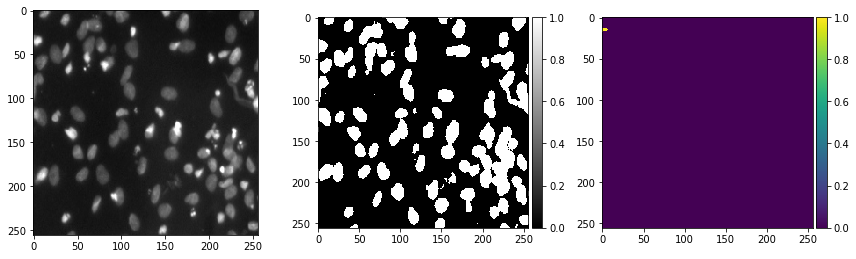

Claras


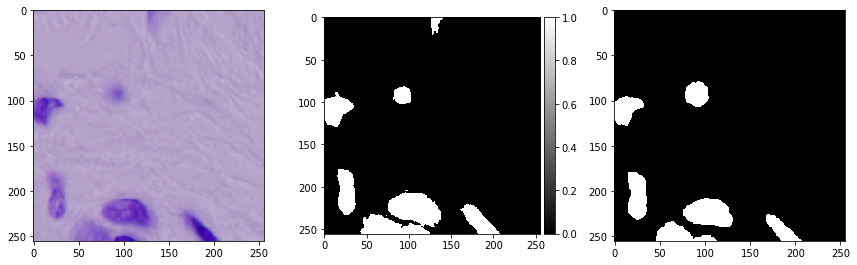

In [9]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
ix = 471

print ('Escuras')
plt.figure(figsize=(12,8))
plt.subplot(231)
imshow(X_train[dict_['Escura']][ix], cmap='gray')
plt.subplot(232)
imshow(binarize(rgb2gray(X_train[dict_['Escura']][ix]), threshold=threshold_otsu(rgb2gray(X_train[dict_['Escura']][ix]))/1.5), cmap='gray')
plt.subplot(233)
imshow(np.squeeze(Y_train[dict_['Escura']][ix]))
plt.show()

print ('Claras')
ix = 0
plt.figure(figsize=(12,8))
plt.subplot(231)
imshow(X_train[ix])
plt.subplot(232)
imshow(1 - binarize(rgb2gray(X_train[ix]), threshold=threshold_otsu(rgb2gray(X_train[ix]))*1.1), cmap='gray')
plt.subplot(233)
imshow(np.squeeze(Y_train[ix]))
plt.show()
plt.show()

Pode se ver ter uma noção pela média das intensidades de pixels nas imagens

In [201]:
dict_test = {'Clara' : [],
        'Escura' : []}
for i, j in enumerate(X_test):
    if (np.mean(j) > 80):
        dict_test['Clara'].append(i)
    else:
        dict_test['Escura'].append(i)
dict_test['Clara'] = np.array(dict_test['Clara'])
dict_test['Escura'] = np.array(dict_test['Escura'])

Com um threshold, conseguimos conseguir um bom resultado para muitas das imagens...

In [11]:
dices = []
for img, ev in zip(X_train[dict_['Escura']], Y_train[dict_['Escura']]):
    dices.append(dice(binarize(rgb2gray(img), threshold=threshold_otsu(rgb2gray(img))/1.5), np.squeeze(ev)))
dices = np.array(dices)
print 'Average dice: ', np.mean(dices)
print 'Worst dice: ', np.min(dices)
print 'Best dice: ', np.max(dices)
print 'Median: ', np.median(dices)

Average dice:  0.898615053523
Worst dice:  6.09198532319e-07
Best dice:  0.992927274435
Median:  0.920282169253


In [12]:
dices_claras = []
for img, ev in zip(X_train[dict_['Clara']], Y_train[dict_['Clara']]):
    dices_claras.append(dice(1 - binarize(rgb2gray(img), threshold=threshold_otsu(rgb2gray(img))), np.squeeze(ev)))
dices_claras = np.array(dices_claras)
print 'Average dice: ', np.mean(dices_claras)
print 'Worst dice: ', np.min(dices_claras)
print 'Best dice: ', np.max(dices_claras)
print 'Median: ', np.median(dices_claras)

Average dice:  0.75315466615
Worst dice:  0.0992995437025
Best dice:  0.927416555337
Median:  0.860757829519


In [13]:
predictions = np.zeros(np.squeeze(Y_train).shape)
for i, img in enumerate(X_train):
    if (i in dict_['Escura']):
        predictions[i] = binarize(rgb2gray(X_train[ix]), threshold=threshold_otsu(rgb2gray(X_train[ix]))/1.5)
    else:
        predictions[i] = binarize(1 - rgb2gray(X_train[ix]), threshold=threshold_otsu(rgb2gray(X_train[ix])))

In [14]:
np.where(dices < 0.5)

(array([110, 151, 293, 370, 442, 471, 489]),)

### Vamos agora ver como fica com um modelo de deep learning

In [15]:
from evaluation import *
from sklearn.model_selection import train_test_split

In [286]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, Y_train, test_size = 0.25, random_state=42)

In [16]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', data_format="channels_last") (c9)

    model = keras_Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [134]:
model = get_unet(IMG_WIDTH=128, IMG_HEIGHT=128)

In [136]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_with_dice.h5', verbose=1, save_best_only=True)
results = model.fit(X_tr, y_tr, validation_data=(X_te, y_te), batch_size=32, epochs=120, 
                    callbacks=[earlystopper, checkpointer])

Train on 502 samples, validate on 168 samples
Epoch 1/120
502/502 [==============================] - 4s 9ms/step - loss: -0.7853 - dice_coef: 0.7853 - val_loss: -0.8073 - val_dice_coef: 0.8073
Epoch 2/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7907 - dice_coef: 0.7907 - val_loss: -0.8069 - val_dice_coef: 0.8069
Epoch 3/120
502/502 [==============================] - 4s 9ms/step - loss: -0.7858 - dice_coef: 0.7858 - val_loss: -0.8085 - val_dice_coef: 0.8085
Epoch 4/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7914 - dice_coef: 0.7914 - val_loss: -0.8072 - val_dice_coef: 0.8072
Epoch 5/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7847 - dice_coef: 0.7847 - val_loss: -0.8073 - val_dice_coef: 0.8073
Epoch 6/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7855 - dice_coef: 0.7855 - val_loss: -0.8082 - val_dice_coef: 0.8082
Epoch 7/120
502/502 [==============================] - 4s 9ms/step - los

Epoch 58/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7956 - dice_coef: 0.7956 - val_loss: -0.8117 - val_dice_coef: 0.8117
Epoch 59/120
502/502 [==============================] - 4s 9ms/step - loss: -0.7905 - dice_coef: 0.7905 - val_loss: -0.8121 - val_dice_coef: 0.8121
Epoch 60/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7962 - dice_coef: 0.7962 - val_loss: -0.8112 - val_dice_coef: 0.8112
Epoch 61/120
502/502 [==============================] - 4s 9ms/step - loss: -0.7961 - dice_coef: 0.7961 - val_loss: -0.8123 - val_dice_coef: 0.8123
Epoch 62/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7984 - dice_coef: 0.7984 - val_loss: -0.8117 - val_dice_coef: 0.8117
Epoch 63/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7959 - dice_coef: 0.7959 - val_loss: -0.8123 - val_dice_coef: 0.8123
Epoch 64/120
502/502 [==============================] - 4s 8ms/step - loss: -0.7979 - dice_coef: 0.7979 - val_lo

In [250]:
model.load_weights('./model_with_dice.h5')

In [251]:
y_prev = model.predict(X_te, verbose=1)

168/168 [==============================] - 0s 1ms/step


In [252]:
# Applying no deep learning algorithm and comparing

In [253]:
dict_te = {'Clara' : [],
        'Escura' : []}
for i, j in enumerate(X_te):
    if (np.mean(j) > 80):
        dict_te['Clara'].append(i)
    else:
        dict_te['Escura'].append(i)
dict_te['Clara'] = np.array(dict_te['Clara'])
dict_te['Escura'] = np.array(dict_te['Escura'])

In [254]:
predictions = np.zeros(np.squeeze(y_te).shape)
for i, img in enumerate(X_te):
    if (i in dict_te['Escura']):
        predictions[i] = binarize(rgb2gray(img), threshold=threshold_otsu(rgb2gray(img))/1.5)
    else:
        predictions[i] = 1 - binarize(rgb2gray(img), threshold=threshold_otsu(rgb2gray(img)))

In [255]:
from ipywidgets import interact, fixed

In [73]:
def show(index, img, cmap='jet'):
    plt.figure(figsize=(10,10))
    plt.imshow(img[:][index], cmap=cmap)
    plt.colorbar()
    plt.show()
    
def display_images(index, img, prev, mask):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,3,figsize=(15,12))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,3,1)
    plt.imshow(img[index],cmap='jet');
    plt.title('vol')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,3,2)
    plt.imshow(prev[:,:,:,0][index] > 0.5,cmap='jet');
    plt.title('predicted')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(mask[:,:,:,0][index],cmap='jet');
    plt.title('mask')
    plt.axis('off')
    
    print (dice(mask[:,:,:,0][index], prev[:,:,:,0][index]>0.40))
    plt.show()

In [257]:
interact(display_images, index = (0, len(X_te)-1),img=fixed(X_te), prev=fixed(y_prev), mask = fixed(y_te))

<function __main__.display_images>

In [258]:
dices_escuras = []
for i in dict_te['Escura']:
    dices_escuras.append(dice(y_prev[i] > 0.5, y_te[i]))
dices_escuras = np.array(dices_escuras)

In [259]:
print 'Average dice: ', np.mean(dices_escuras)
print 'Worst dice: ', np.min(dices_escuras)
print 'Best dice: ', np.max(dices_escuras)
print 'Median: ', np.median(dices_escuras)

Average dice:  0.938578743463
Worst dice:  0.717951211749
Best dice:  0.988059879703
Median:  0.955117099487


In [263]:
dict_te['Clara']

array([  3,   9,  11,  17,  26,  35,  37,  38,  42,  47,  49,  50,  64,
        66,  71,  79,  95,  99, 100, 104, 123, 125, 131, 136, 138, 140,
       142, 153, 158, 161, 164])

In [267]:
dices_claras = []

for i in dict_te['Clara']:
    dices_claras.append(dice(y_prev[i] > 0.5, y_te[i]))
dices_claras = np.array(dices_claras)

In [268]:
print 'Average dice: ', np.mean(dices_claras)
print 'Worst dice: ', np.min(dices_claras)
print 'Best dice: ', np.max(dices_claras)
print 'Median: ', np.median(dices_claras)

Average dice:  9.10481190517e-06
Worst dice:  9.91079295263e-07
Best dice:  4.69461527628e-05
Median:  3.1867329932e-06


## Pelo jeito vamos precisar de um modelo de deep learning apenas para as imagens claras, e um apenas para as escuras...

### Escuras

In [17]:
X_escuras = X_train[dict_['Escura']]
y_escuras = Y_train[dict_['Escura']]

In [18]:
X_tr, X_te, y_tr, y_te = train_test_split(X_escuras, y_escuras, test_size = 0.25, random_state=42)

In [19]:
model = get_unet(IMG_WIDTH=256, IMG_HEIGHT=256)

In [20]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_256_escuras_with_dice.h5', verbose=1, save_best_only=True)
results = model.fit(X_tr, y_tr, validation_data=(X_te, y_te), batch_size=32, epochs=120, 
                    callbacks=[earlystopper, checkpointer])

Train on 409 samples, validate on 137 samples
Epoch 1/120
409/409 [==============================] - 12s 29ms/step - loss: -0.3810 - dice_coef: 0.3810 - val_loss: -0.7279 - val_dice_coef: 0.7279
Epoch 2/120
409/409 [==============================] - 7s 18ms/step - loss: -0.7767 - dice_coef: 0.7767 - val_loss: -0.7343 - val_dice_coef: 0.7343
Epoch 3/120
409/409 [==============================] - 7s 17ms/step - loss: -0.8323 - dice_coef: 0.8323 - val_loss: -0.8711 - val_dice_coef: 0.8711
Epoch 4/120
409/409 [==============================] - 7s 17ms/step - loss: -0.8774 - dice_coef: 0.8774 - val_loss: -0.8958 - val_dice_coef: 0.8958
Epoch 5/120
409/409 [==============================] - 7s 17ms/step - loss: -0.8926 - dice_coef: 0.8926 - val_loss: -0.8772 - val_dice_coef: 0.8772
Epoch 6/120
409/409 [==============================] - 7s 17ms/step - loss: -0.8966 - dice_coef: 0.8966 - val_loss: -0.9058 - val_dice_coef: 0.9058
Epoch 7/120
409/409 [==============================] - 7s 17ms/st

Epoch 27/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9250 - dice_coef: 0.9250 - val_loss: -0.9273 - val_dice_coef: 0.9273
Epoch 28/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9255 - dice_coef: 0.9255 - val_loss: -0.9293 - val_dice_coef: 0.9293
Epoch 29/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9235 - dice_coef: 0.9235 - val_loss: -0.9276 - val_dice_coef: 0.9276
Epoch 30/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9243 - dice_coef: 0.9243 - val_loss: -0.9241 - val_dice_coef: 0.9241
Epoch 31/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9252 - dice_coef: 0.9252 - val_loss: -0.9294 - val_dice_coef: 0.9294
Epoch 32/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9252 - dice_coef: 0.9252 - val_loss: -0.9303 - val_dice_coef: 0.9303
Epoch 33/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9251 - dice_coef: 0.9251 -

409/409 [==============================] - 7s 17ms/step - loss: -0.9349 - dice_coef: 0.9349 - val_loss: -0.9313 - val_dice_coef: 0.9313
Epoch 56/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9319 - dice_coef: 0.9319 - val_loss: -0.9315 - val_dice_coef: 0.9315
Epoch 57/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9333 - dice_coef: 0.9333 - val_loss: -0.9314 - val_dice_coef: 0.9314
Epoch 58/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9354 - dice_coef: 0.9354 - val_loss: -0.9318 - val_dice_coef: 0.9318
Epoch 59/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9350 - dice_coef: 0.9350 - val_loss: -0.9311 - val_dice_coef: 0.9311
Epoch 60/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9345 - dice_coef: 0.9345 - val_loss: -0.9310 - val_dice_coef: 0.9310
Epoch 61/120
409/409 [==============================] - 7s 17ms/step - loss: -0.9341 - dice_coef: 0.9341 - val_loss: -0

In [21]:
model.load_weights('./model_256_escuras_with_dice.h5')

In [22]:
y_prev = model.predict(X_te, verbose=1)

137/137 [==============================] - 1s 4ms/step


In [71]:
dices_escuras = []
for i in range(len(X_te)):
    dices_escuras.append(dice(y_prev[i] > .5, y_te[i]))
dices_escuras = np.array(dices_escuras)

In [72]:
print 'Average dice: ', np.mean(dices_escuras)
print 'Worst dice: ', np.min(dices_escuras)
print 'Best dice: ', np.max(dices_escuras)
print 'Median: ', np.median(dices_escuras)

Average dice:  0.926934415934
Worst dice:  0.774056258571
Best dice:  0.981054822499
Median:  0.941196121614


In [76]:
interact(display_images, index = (0, len(X_te)-1),img=fixed(X_te), prev=fixed(y_prev), mask = fixed(y_te))

<function __main__.display_images>

### Escuras

In [77]:
X_claras = X_train[dict_['Clara']]
y_claras = Y_train[dict_['Clara']]

In [86]:
from pre_train import data_augmentation

In [80]:
X_tr_cla, X_te_cla, y_tr_cla, y_te_cla = train_test_split(X_claras, y_claras, test_size = 0.25, random_state=42)

In [166]:
def z_score(img):
    return (img - K.mean(img)) / K.std(img)

In [167]:
def get_unet_grayscale(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    s = Lambda(lambda x: z_score(x)) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', data_format="channels_last") (c9)

    model = keras_Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [110]:
X_tr_gray = []
X_te_gray = []
for img in tqdm_notebook(X_tr_cla):
    X_tr_gray.append(rgb2gray(img))
for img in tqdm_notebook(X_te_cla):
    X_te_gray.append(rgb2gray(img))

X_tr_gray = np.array(X_tr_gray)
X_te_gray = np.array(X_te_gray)

In [123]:
X_tr_gray = pre_reshape(X_tr_gray) 
X_te_gray = pre_reshape(X_te_gray)

In [157]:
aug = data_augmentation(X_tr_gray, y_tr_cla, horizontal_flip=True, translation_range=(.05,.05), vertical_flip=True, zoom_range=0)

In [168]:
model = get_unet_grayscale(IMG_WIDTH=256, IMG_HEIGHT=256, IMG_CHANNELS=1)

In [174]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_256_claras_with_dice.h5', verbose=1, save_best_only=True)
results = model.fit(X_tr_gray, y_tr_cla, validation_data=(X_te_gray, y_te_cla), batch_size=32, epochs=120, 
                    callbacks=[earlystopper, checkpointer])
# model.fit_generator(aug, epochs=25, steps_per_epoch=50,
#                          validation_data=(X_te_gray, y_te_cla), callbacks=[earlystopper, checkpointer])

Train on 93 samples, validate on 31 samples
Epoch 1/120
93/93 [==============================] - 2s 18ms/step - loss: -0.7441 - dice_coef: 0.7441 - val_loss: -0.8124 - val_dice_coef: 0.8124
Epoch 2/120
93/93 [==============================] - 2s 17ms/step - loss: -0.7448 - dice_coef: 0.7448 - val_loss: -0.7912 - val_dice_coef: 0.7912
Epoch 3/120
93/93 [==============================] - 2s 19ms/step - loss: -0.8037 - dice_coef: 0.8037 - val_loss: -0.8318 - val_dice_coef: 0.8318
Epoch 4/120
93/93 [==============================] - 2s 19ms/step - loss: -0.8196 - dice_coef: 0.8196 - val_loss: -0.8349 - val_dice_coef: 0.8349
Epoch 5/120
93/93 [==============================] - 2s 18ms/step - loss: -0.8061 - dice_coef: 0.8061 - val_loss: -0.7807 - val_dice_coef: 0.7807
Epoch 6/120
93/93 [==============================] - 2s 18ms/step - loss: -0.8007 - dice_coef: 0.8007 - val_loss: -0.7658 - val_dice_coef: 0.7658
Epoch 7/120
93/93 [==============================] - 2s 17ms/step - loss: -0.815

Epoch 28/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8447 - dice_coef: 0.8447 - val_loss: -0.8600 - val_dice_coef: 0.8600
Epoch 29/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8466 - dice_coef: 0.8466 - val_loss: -0.8601 - val_dice_coef: 0.8601
Epoch 30/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8486 - dice_coef: 0.8486 - val_loss: -0.8585 - val_dice_coef: 0.8585
Epoch 31/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8458 - dice_coef: 0.8458 - val_loss: -0.8560 - val_dice_coef: 0.8560
Epoch 32/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8463 - dice_coef: 0.8463 - val_loss: -0.8545 - val_dice_coef: 0.8545
Epoch 33/120
93/93 [==============================] - 2s 18ms/step - loss: -0.8413 - dice_coef: 0.8413 - val_loss: -0.8624 - val_dice_coef: 0.8624
Epoch 34/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8466 - dice_coef: 0.8466 - val_loss: -0.

Epoch 58/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8549 - dice_coef: 0.8549 - val_loss: -0.8559 - val_dice_coef: 0.8559
Epoch 59/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8489 - dice_coef: 0.8489 - val_loss: -0.8665 - val_dice_coef: 0.8665
Epoch 60/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8484 - dice_coef: 0.8484 - val_loss: -0.8625 - val_dice_coef: 0.8625
Epoch 61/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8539 - dice_coef: 0.8539 - val_loss: -0.8581 - val_dice_coef: 0.8581
Epoch 62/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8484 - dice_coef: 0.8484 - val_loss: -0.8662 - val_dice_coef: 0.8662
Epoch 63/120
93/93 [==============================] - 2s 18ms/step - loss: -0.8581 - dice_coef: 0.8581 - val_loss: -0.8723 - val_dice_coef: 0.8723
Epoch 64/120
93/93 [==============================] - 2s 18ms/step - loss: -0.8550 - dice_coef: 0.8550 - val_loss: -0.

Epoch 88/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8604 - dice_coef: 0.8604 - val_loss: -0.8658 - val_dice_coef: 0.8658
Epoch 89/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8616 - dice_coef: 0.8616 - val_loss: -0.8737 - val_dice_coef: 0.8737
Epoch 90/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8633 - dice_coef: 0.8633 - val_loss: -0.8713 - val_dice_coef: 0.8713
Epoch 91/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8626 - dice_coef: 0.8626 - val_loss: -0.8741 - val_dice_coef: 0.8741
Epoch 92/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8641 - dice_coef: 0.8641 - val_loss: -0.8742 - val_dice_coef: 0.8742
Epoch 93/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8659 - dice_coef: 0.8659 - val_loss: -0.8709 - val_dice_coef: 0.8709
Epoch 94/120
93/93 [==============================] - 2s 17ms/step - loss: -0.8667 - dice_coef: 0.8667 - val_loss: -0.

In [175]:
model.load_weights('./model_256_claras_with_dice.h5')

In [176]:
y_prev_cla = model.predict(X_te_gray, verbose=1)

31/31 [==============================] - 0s 3ms/step


In [177]:
def show(index, img, cmap='jet'):
    plt.figure(figsize=(10,10))
    plt.imshow(img[:][index], cmap=cmap)
    plt.colorbar()
    plt.show()
    
def display_images(index, img, prev, mask):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,3,figsize=(15,12))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,3,1)
    plt.imshow(img[index],cmap='jet');
    plt.title('vol')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,3,2)
    plt.imshow(prev[:,:,:,0][index] > 0.5,cmap='jet');
    plt.title('predicted')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(mask[:,:,:,0][index],cmap='jet');
    plt.title('mask')
    plt.axis('off')
    
    print (dice(mask[:,:,:,0][index], prev[:,:,:,0][index]>0.40))
    plt.show()

In [178]:
interact(display_images, index = (0, len(X_te_cla)-1),img=fixed(X_te_cla), prev=fixed(y_prev_cla), mask = fixed(y_te_cla))

<function __main__.display_images>

In [187]:
dices_claras = []
for i in range(len(X_te_cla)):
    dices_claras.append(dice(y_prev_cla[i] > .45, y_te_cla[i]))
dices_claras = np.array(dices_claras)

In [188]:
print 'Average dice: ', np.mean(dices_claras)
print 'Worst dice: ', np.min(dices_claras)
print 'Best dice: ', np.max(dices_claras)
print 'Median: ', np.median(dices_claras)

Average dice:  0.822146790236
Worst dice:  0.43465657957
Best dice:  0.934122653368
Median:  0.880180643415


## Vamo fazer nossa primeira submissão

In [189]:
from evaluation import rle_encoding, prob_to_rles

In [205]:
interact(show, index = (0, len(X_test)), img=fixed(X_test))

<function __main__.show>

In [202]:
dict_test

{'Clara': array([ 1,  4,  8, 18, 27, 28, 31, 40, 44, 48, 58, 62]),
 'Escura': array([ 0,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20,
        21, 22, 23, 24, 25, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 41,
        42, 43, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61,
        63, 64])}

In [213]:
## Preparing img for each case
teste_claras = []
for img in X_test[dict_test['Clara']]:
    teste_claras.append(rgb2gray(img))
teste_claras = pre_reshape(np.array(teste_claras))
teste_escuras = pre_reshape(X_test[dict_test['Escura']])

In [206]:
model = get_unet(IMG_CHANNELS=3, IMG_HEIGHT=256, IMG_WIDTH=256)

In [207]:
model.load_weights('./model_256_escuras_with_dice.h5')

In [208]:
model2 = get_unet_grayscale(IMG_CHANNELS=1, IMG_HEIGHT=256, IMG_WIDTH=256)

In [209]:
model2.load_weights('./model_256_claras_with_dice.h5')

In [216]:
prev_escuras = model.predict(teste_escuras, verbose=1)
prev_claras = model2.predict(teste_claras, verbose=1)

12/12 [==============================] - 1s 62ms/step


In [218]:
prev_escuras  = (prev_escuras > 0.5).astype(np.uint8)
prev_claras  = (prev_claras > 0.5).astype(np.uint8)

In [219]:
interact(display_images, index = (0, len(X_test[dict_test['Escura']])-1), img=fixed(X_test[dict_test['Escura']]), prev=fixed(prev_escuras), mask = fixed(prev_escuras))

<function __main__.display_images>

In [221]:
interact(display_images, index = (0, len(X_test[dict_test['Clara']])-1), img=fixed(X_test[dict_test['Clara']]), prev=fixed(prev_claras), mask = fixed(prev_claras))

<function __main__.display_images>

In [228]:
all_prevs = np.zeros((len(X_test),256,256,1))
all_prevs[dict_test['Clara']] = prev_claras
all_prevs[dict_test['Escura']] = prev_escuras

In [230]:
interact(display_images, index = (0, len(X_test)-1), img=fixed(X_test), prev=fixed(all_prevs), mask = fixed(all_prevs))

<function __main__.display_images>

In [231]:
from skimage.transform import resize

In [237]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [234]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(all_prevs)):
    preds_test_upsampled.append(resize(np.squeeze(all_prevs[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [238]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [239]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('Primeira_UNET.csv', index=False)